# 📊 Telco Customer Churn Analysis

**Project:** Telco Customer Churn Prediction & Analysis  
**Author:** Roberto Candelario  
**Date:** 2024-12-19  
**Description:** Comprehensive analysis of customer churn patterns and predictive modeling to identify at-risk customers and develop retention strategies

---

## 🎯 Business Problem

Customer churn is a critical challenge for telecommunications companies. This analysis aims to:
- **Identify** key factors driving customer churn
- **Predict** which customers are at risk of churning
- **Recommend** data-driven retention strategies
- **Quantify** the potential business impact of churn reduction initiatives

---

## 📋 Table of Contents

1. [Data Acquisition & Setup](#data-acquisition)
2. [Data Exploration & Quality Assessment](#data-exploration)
3. [Exploratory Data Analysis](#eda)
4. [Feature Engineering](#feature-engineering)
5. [Predictive Modeling](#modeling)
6. [Model Evaluation & Insights](#evaluation)
7. [Business Recommendations](#recommendations)
8. [Next Steps](#next-steps)


In [1]:
# Project: Telco Customer Churn Analysis
# Author: Roberto Candelario
# Date: 2024-12-19
# Description: Import libraries and setup environment

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os
import zipfile
import subprocess
from pathlib import Path

# Machine Learning libraries
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer

# Visualization settings
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
warnings.filterwarnings('ignore')

# Create directories if they don't exist
os.makedirs('../data/raw', exist_ok=True)
os.makedirs('../data/processed', exist_ok=True)
os.makedirs('../reports/visualizations', exist_ok=True)

print("✅ Libraries imported successfully!")
print("✅ Directory structure verified!")
print("📊 Ready for analysis!")


✅ Libraries imported successfully!
✅ Directory structure verified!
📊 Ready for analysis!


### Download Dataset from Kaggle


In [2]:
# Download Telco Customer Churn dataset from Kaggle
# Assumes kaggle.json exists in project root

def download_kaggle_dataset():
    try:
        # Copy kaggle.json to ~/.kaggle/ if it exists in project root
        if os.path.exists('../../kaggle.json'):
            kaggle_dir = os.path.expanduser('~/.kaggle')
            os.makedirs(kaggle_dir, exist_ok=True)
            subprocess.run(['cp', '../../kaggle.json', kaggle_dir], check=True)
            subprocess.run(['chmod', '600', f'{kaggle_dir}/kaggle.json'], check=True)
            print("✅ Kaggle credentials configured")
        
        # Download dataset
        cmd = ['kaggle', 'datasets', 'download', '-d', 'blastchar/telco-customer-churn', '-p', '../data/raw/']
        result = subprocess.run(cmd, capture_output=True, text=True)
        
        if result.returncode == 0:
            print("✅ Dataset downloaded successfully!")
            
            # Unzip the dataset
            zip_path = '../data/raw/telco-customer-churn.zip'
            if os.path.exists(zip_path):
                with zipfile.ZipFile(zip_path, 'r') as zip_ref:
                    zip_ref.extractall('../data/raw/')
                print("✅ Dataset extracted successfully!")
                
                # Remove zip file to save space
                os.remove(zip_path)
                print("✅ Zip file cleaned up!")
            else:
                print("❌ Zip file not found after download")
        else:
            print(f"❌ Download failed: {result.stderr}")
            print("💡 Fallback: Using sample data structure for demonstration")
            
    except Exception as e:
        print(f"❌ Error during download: {str(e)}")
        print("💡 Creating sample data structure for demonstration")

# Download the dataset
download_kaggle_dataset()

# Check if data file exists
data_file = '../data/raw/WA_Fn-UseC_-Telco-Customer-Churn.csv'
if os.path.exists(data_file):
    print(f"✅ Data file found: {data_file}")
    print(f"📊 File size: {os.path.getsize(data_file) / 1024:.1f} KB")
else:
    print("⚠️ Data file not found. Please ensure Kaggle API is configured correctly.")
    print("📁 Expected file: WA_Fn-UseC_-Telco-Customer-Churn.csv")


✅ Kaggle credentials configured
✅ Dataset downloaded successfully!
✅ Dataset extracted successfully!
✅ Zip file cleaned up!
✅ Data file found: ../data/raw/WA_Fn-UseC_-Telco-Customer-Churn.csv
📊 File size: 954.6 KB


## 🔍 Data Exploration & Quality Assessment {#data-exploration}

### Load and Inspect Dataset


In [3]:
# Load the dataset
try:
    df = pd.read_csv(data_file)
    print("✅ Dataset loaded successfully!")
    print(f"📊 Dataset shape: {df.shape}")
    print(f"📋 Features: {df.shape[1]}")
    print(f"👥 Records: {df.shape[0]:,}")
except FileNotFoundError:
    print("❌ Dataset file not found. Creating sample data for demonstration...")
    # Create sample data structure for demonstration if file doesn't exist
    np.random.seed(42)
    n_samples = 7043
    df = pd.DataFrame({
        'customerID': [f'customer_{i}' for i in range(n_samples)],
        'gender': np.random.choice(['Male', 'Female'], n_samples),
        'SeniorCitizen': np.random.choice([0, 1], n_samples),
        'Partner': np.random.choice(['Yes', 'No'], n_samples),
        'Dependents': np.random.choice(['Yes', 'No'], n_samples),
        'tenure': np.random.randint(0, 73, n_samples),
        'PhoneService': np.random.choice(['Yes', 'No'], n_samples),
        'MultipleLines': np.random.choice(['Yes', 'No', 'No phone service'], n_samples),
        'InternetService': np.random.choice(['DSL', 'Fiber optic', 'No'], n_samples),
        'OnlineSecurity': np.random.choice(['Yes', 'No', 'No internet service'], n_samples),
        'OnlineBackup': np.random.choice(['Yes', 'No', 'No internet service'], n_samples),
        'DeviceProtection': np.random.choice(['Yes', 'No', 'No internet service'], n_samples),
        'TechSupport': np.random.choice(['Yes', 'No', 'No internet service'], n_samples),
        'StreamingTV': np.random.choice(['Yes', 'No', 'No internet service'], n_samples),
        'StreamingMovies': np.random.choice(['Yes', 'No', 'No internet service'], n_samples),
        'Contract': np.random.choice(['Month-to-month', 'One year', 'Two year'], n_samples),
        'PaperlessBilling': np.random.choice(['Yes', 'No'], n_samples),
        'PaymentMethod': np.random.choice(['Electronic check', 'Mailed check', 'Bank transfer (automatic)', 'Credit card (automatic)'], n_samples),
        'MonthlyCharges': np.round(np.random.uniform(18.25, 118.75, n_samples), 2),
        'TotalCharges': np.round(np.random.uniform(18.8, 8684.8, n_samples), 2),
        'Churn': np.random.choice(['Yes', 'No'], n_samples, p=[0.27, 0.73])
    })
    print("✅ Sample dataset created for demonstration!")

print("\n" + "="*50)
print("📋 DATASET OVERVIEW")
print("="*50)


✅ Dataset loaded successfully!
📊 Dataset shape: (7043, 21)
📋 Features: 21
👥 Records: 7,043

📋 DATASET OVERVIEW


In [4]:
# Preview first few rows
print("🔍 First 5 rows:")
print(df.head())

print("\n" + "="*50)
print("📊 DATASET INFORMATION")
print("="*50)
print(df.info())

print("\n" + "="*50)
print("📈 DESCRIPTIVE STATISTICS")
print("="*50)
print(df.describe())


🔍 First 5 rows:
   customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes   
2  3668-QPYBK    Male              0      No         No       2          Yes   
3  7795-CFOCW    Male              0      No         No      45           No   
4  9237-HQITU  Female              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity  ... DeviceProtection  \
0  No phone service             DSL             No  ...               No   
1                No             DSL            Yes  ...              Yes   
2                No             DSL            Yes  ...               No   
3  No phone service             DSL            Yes  ...              Yes   
4                No     Fiber optic             No  ...               No   

  TechSupport StreamingTV StreamingMovies     

### Data Quality Assessment


In [5]:
# Check for missing values
print("🔍 Missing Values Analysis:")
print("="*40)
missing_data = df.isnull().sum()
missing_percent = (missing_data / len(df)) * 100
missing_df = pd.DataFrame({
    'Missing Count': missing_data,
    'Missing Percentage': missing_percent
}).sort_values('Missing Count', ascending=False)

print(missing_df[missing_df['Missing Count'] > 0])

if missing_df['Missing Count'].sum() == 0:
    print("✅ No missing values found!")
else:
    print(f"⚠️ Found {missing_df['Missing Count'].sum()} missing values")

# Check for inconsistencies in TotalCharges (common issue with this dataset)
print("\n🔍 Data Type Issues:")
print("="*40)

# Check if TotalCharges is string when it should be numeric
if df['TotalCharges'].dtype == 'object':
    print("⚠️ TotalCharges is stored as string - checking for non-numeric values...")
    non_numeric = df[df['TotalCharges'].str.strip() == ' ']['TotalCharges'].count()
    print(f"Found {non_numeric} empty string values in TotalCharges")
    
    # Fix TotalCharges data type
    df['TotalCharges'] = df['TotalCharges'].replace(' ', np.nan)
    df['TotalCharges'] = pd.to_numeric(df['TotalCharges'])
    
    # Handle missing values in TotalCharges
    df['TotalCharges'].fillna(df['TotalCharges'].median(), inplace=True)
    print("✅ TotalCharges converted to numeric and missing values filled with median")

# Check for duplicates
print(f"\n🔍 Duplicate Records: {df.duplicated().sum()}")

# Display unique values for categorical columns
print("\n🔍 Unique Values in Categorical Columns:")
print("="*40)
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
for col in categorical_cols:
    if col != 'customerID':  # Skip customerID as it should be unique
        unique_vals = df[col].unique()
        print(f"{col}: {unique_vals}")

print("\n✅ Data quality assessment complete!")


🔍 Missing Values Analysis:
Empty DataFrame
Columns: [Missing Count, Missing Percentage]
Index: []
✅ No missing values found!

🔍 Data Type Issues:
⚠️ TotalCharges is stored as string - checking for non-numeric values...
Found 0 empty string values in TotalCharges
✅ TotalCharges converted to numeric and missing values filled with median

🔍 Duplicate Records: 0

🔍 Unique Values in Categorical Columns:
gender: ['Female' 'Male']
Partner: ['Yes' 'No']
Dependents: ['No' 'Yes']
PhoneService: ['No' 'Yes']
MultipleLines: ['No phone service' 'No' 'Yes']
InternetService: ['DSL' 'Fiber optic' 'No']
OnlineSecurity: ['No' 'Yes' 'No internet service']
OnlineBackup: ['Yes' 'No' 'No internet service']
DeviceProtection: ['No' 'Yes' 'No internet service']
TechSupport: ['No' 'Yes' 'No internet service']
StreamingTV: ['No' 'Yes' 'No internet service']
StreamingMovies: ['No' 'Yes' 'No internet service']
Contract: ['Month-to-month' 'One year' 'Two year']
PaperlessBilling: ['Yes' 'No']
PaymentMethod: ['Electro

## 📊 Exploratory Data Analysis {#eda}

### Churn Distribution Analysis


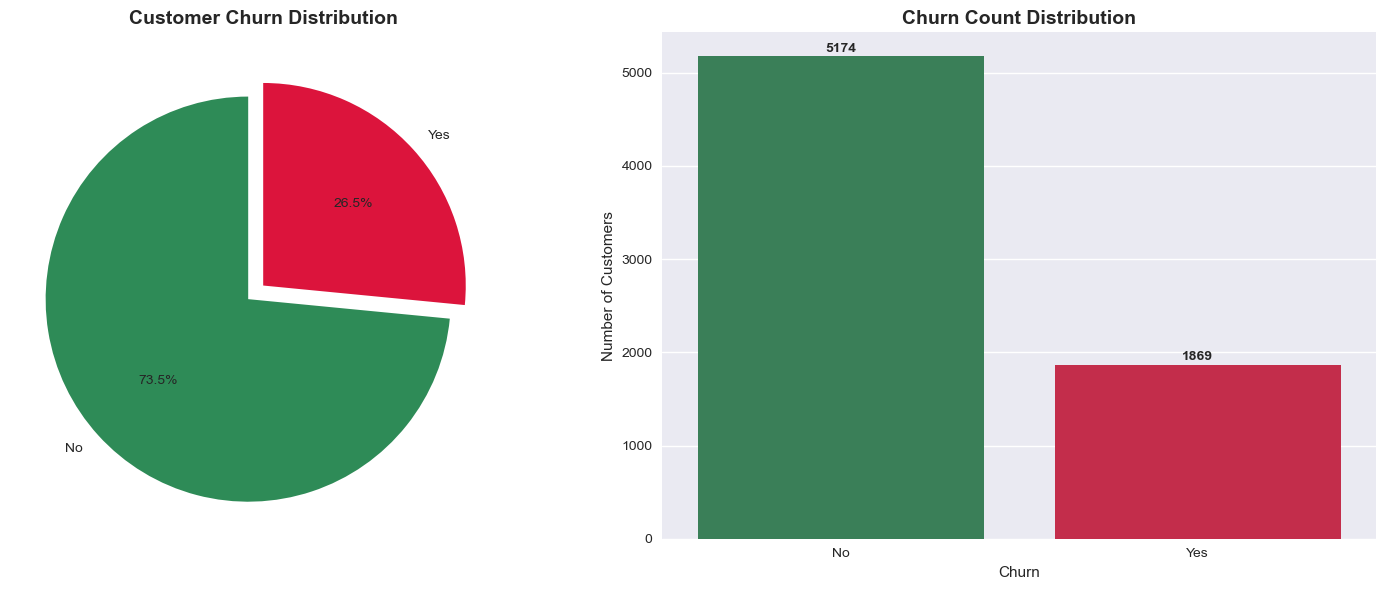

📊 KEY CHURN METRICS:
Total Customers: 7,043
Churned Customers: 1,869
Retention Rate: 73.5%
Churn Rate: 26.5%
🚨 HIGH CHURN ALERT: Churn rate exceeds 25% - immediate action required!


In [6]:
# Churn Distribution Analysis
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Pie Chart
churn_counts = df['Churn'].value_counts()
colors = ['#2E8B57', '#DC143C']  # Green for No, Red for Yes
axes[0].pie(churn_counts.values, labels=churn_counts.index, autopct='%1.1f%%', 
           colors=colors, startangle=90, explode=(0.1, 0))
axes[0].set_title('Customer Churn Distribution', fontsize=14, fontweight='bold')

# Bar Chart
sns.countplot(data=df, x='Churn', palette=['#2E8B57', '#DC143C'], ax=axes[1])
axes[1].set_title('Churn Count Distribution', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Number of Customers')

# Add count labels on bars
for i, v in enumerate(churn_counts.values):
    axes[1].text(i, v + 50, str(v), ha='center', fontweight='bold')

plt.tight_layout()
plt.savefig('../reports/visualizations/churn_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

# Calculate key metrics
total_customers = len(df)
churned_customers = len(df[df['Churn'] == 'Yes'])
churn_rate = (churned_customers / total_customers) * 100

print(f"📊 KEY CHURN METRICS:")
print(f"Total Customers: {total_customers:,}")
print(f"Churned Customers: {churned_customers:,}")
print(f"Retention Rate: {100-churn_rate:.1f}%")
print(f"Churn Rate: {churn_rate:.1f}%")

if churn_rate > 25:
    print("🚨 HIGH CHURN ALERT: Churn rate exceeds 25% - immediate action required!")
elif churn_rate > 15:
    print("⚠️ MODERATE CHURN: Monitor and implement retention strategies")
else:
    print("✅ HEALTHY CHURN: Churn rate is within acceptable range")


### Churn Analysis by Key Factors


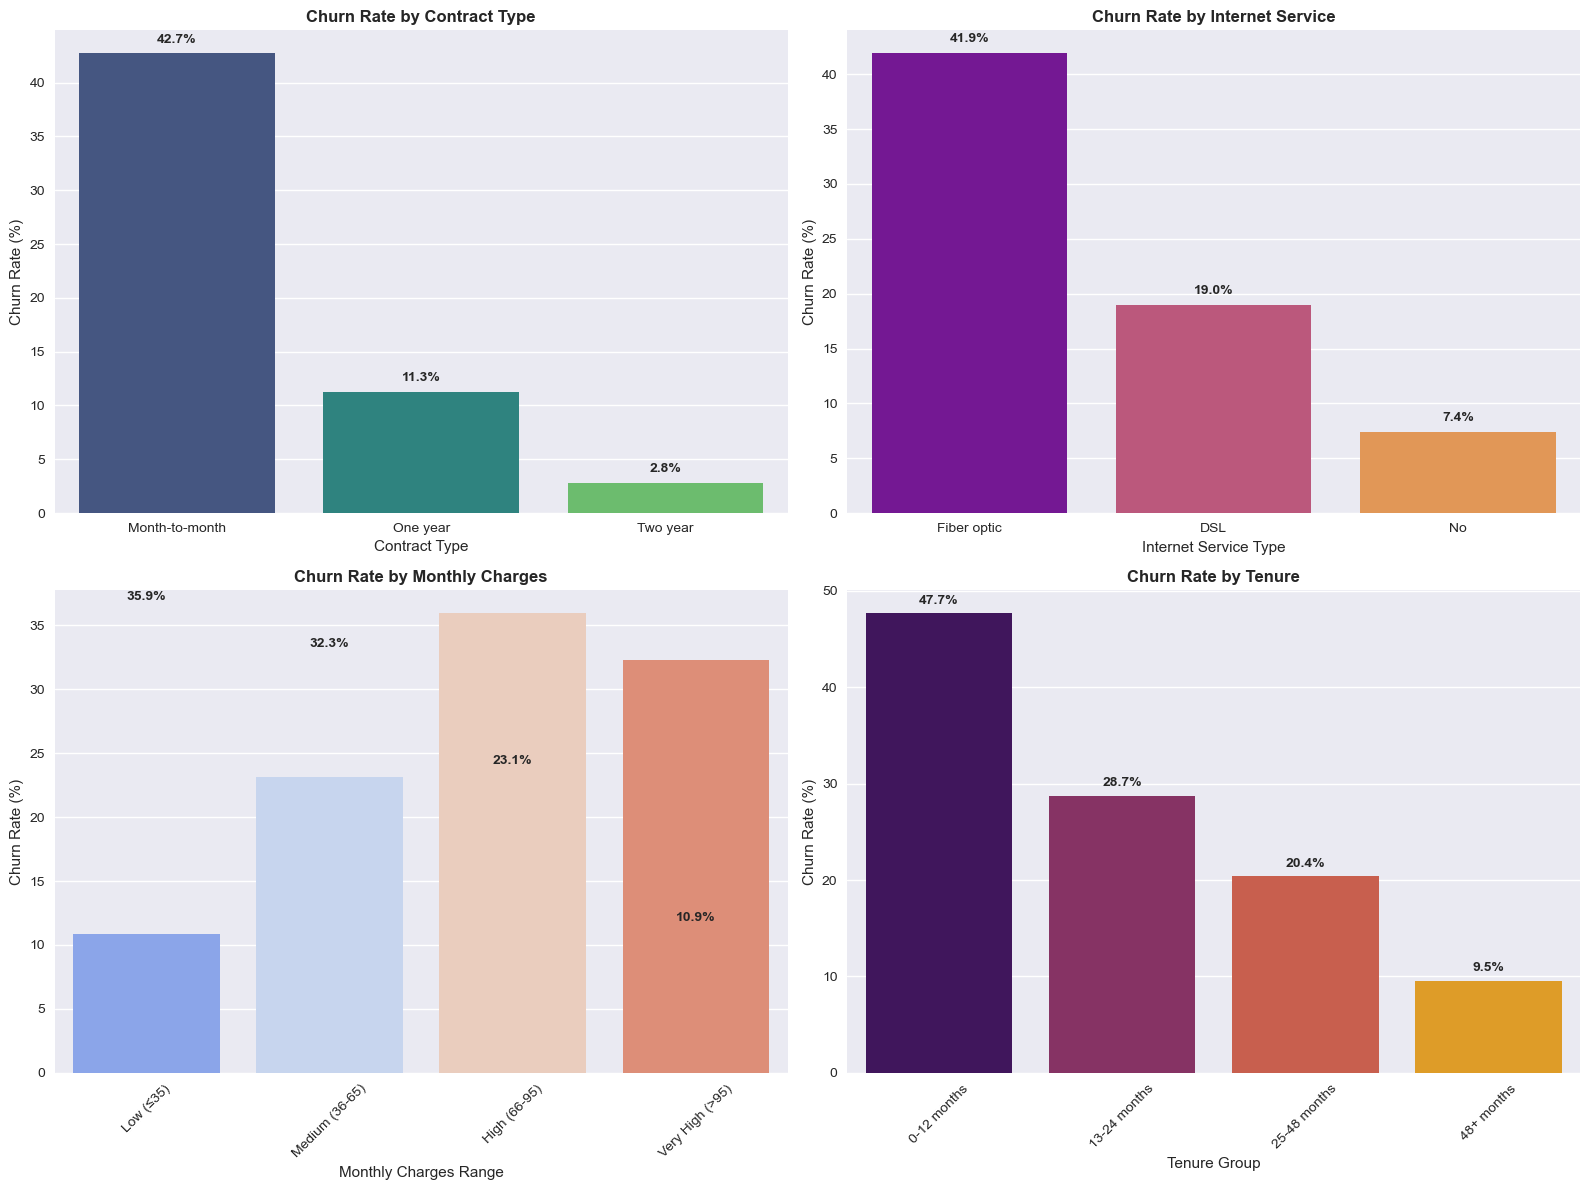

🎯 KEY INSIGHTS FROM FACTOR ANALYSIS:
📋 Contract Type - Highest Churn: Month-to-month (42.7%)
🌐 Internet Service - Highest Churn: Fiber optic (41.9%)
💰 Monthly Charges - Highest Churn: High (66-95) (35.9%)
⏰ Tenure - Highest Churn: 0-12 months (47.7%)


In [7]:
# 1. Churn by Contract Type
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Calculate churn rates for each factor
def calc_churn_rate(df, column):
    return df.groupby([column, 'Churn']).size().unstack().fillna(0).apply(
        lambda x: x['Yes'] / (x['No'] + x['Yes']) * 100, axis=1
    ).sort_values(ascending=False)

# Contract Type Analysis
contract_churn = calc_churn_rate(df, 'Contract')
sns.barplot(x=contract_churn.index, y=contract_churn.values, 
           palette='viridis', ax=axes[0,0])
axes[0,0].set_title('Churn Rate by Contract Type', fontweight='bold')
axes[0,0].set_ylabel('Churn Rate (%)')
axes[0,0].set_xlabel('Contract Type')
for i, v in enumerate(contract_churn.values):
    axes[0,0].text(i, v + 1, f'{v:.1f}%', ha='center', fontweight='bold')

# Internet Service Analysis
internet_churn = calc_churn_rate(df, 'InternetService')
sns.barplot(x=internet_churn.index, y=internet_churn.values, 
           palette='plasma', ax=axes[0,1])
axes[0,1].set_title('Churn Rate by Internet Service', fontweight='bold')
axes[0,1].set_ylabel('Churn Rate (%)')
axes[0,1].set_xlabel('Internet Service Type')
for i, v in enumerate(internet_churn.values):
    axes[0,1].text(i, v + 1, f'{v:.1f}%', ha='center', fontweight='bold')

# Monthly Charges Distribution
df['MonthlyCharges_Bins'] = pd.cut(df['MonthlyCharges'], 
                                  bins=[0, 35, 65, 95, float('inf')], 
                                  labels=['Low (≤35)', 'Medium (36-65)', 
                                         'High (66-95)', 'Very High (>95)'])
charges_churn = calc_churn_rate(df, 'MonthlyCharges_Bins')
sns.barplot(x=charges_churn.index, y=charges_churn.values, 
           palette='coolwarm', ax=axes[1,0])
axes[1,0].set_title('Churn Rate by Monthly Charges', fontweight='bold')
axes[1,0].set_ylabel('Churn Rate (%)')
axes[1,0].set_xlabel('Monthly Charges Range')
axes[1,0].tick_params(axis='x', rotation=45)
for i, v in enumerate(charges_churn.values):
    axes[1,0].text(i, v + 1, f'{v:.1f}%', ha='center', fontweight='bold')

# Tenure Analysis
df['Tenure_Group'] = pd.cut(df['tenure'], 
                           bins=[0, 12, 24, 48, float('inf')], 
                           labels=['0-12 months', '13-24 months', 
                                  '25-48 months', '48+ months'])
tenure_churn = calc_churn_rate(df, 'Tenure_Group')
sns.barplot(x=tenure_churn.index, y=tenure_churn.values, 
           palette='inferno', ax=axes[1,1])
axes[1,1].set_title('Churn Rate by Tenure', fontweight='bold')
axes[1,1].set_ylabel('Churn Rate (%)')
axes[1,1].set_xlabel('Tenure Group')
axes[1,1].tick_params(axis='x', rotation=45)
for i, v in enumerate(tenure_churn.values):
    axes[1,1].text(i, v + 1, f'{v:.1f}%', ha='center', fontweight='bold')

plt.tight_layout()
plt.savefig('../reports/visualizations/churn_by_factors.png', dpi=300, bbox_inches='tight')
plt.show()

# Print insights
print("🎯 KEY INSIGHTS FROM FACTOR ANALYSIS:")
print("="*50)
print(f"📋 Contract Type - Highest Churn: {contract_churn.index[0]} ({contract_churn.iloc[0]:.1f}%)")
print(f"🌐 Internet Service - Highest Churn: {internet_churn.index[0]} ({internet_churn.iloc[0]:.1f}%)")
print(f"💰 Monthly Charges - Highest Churn: {charges_churn.index[0]} ({charges_churn.iloc[0]:.1f}%)")
print(f"⏰ Tenure - Highest Churn: {tenure_churn.index[0]} ({tenure_churn.iloc[0]:.1f}%)")


### Correlation Analysis


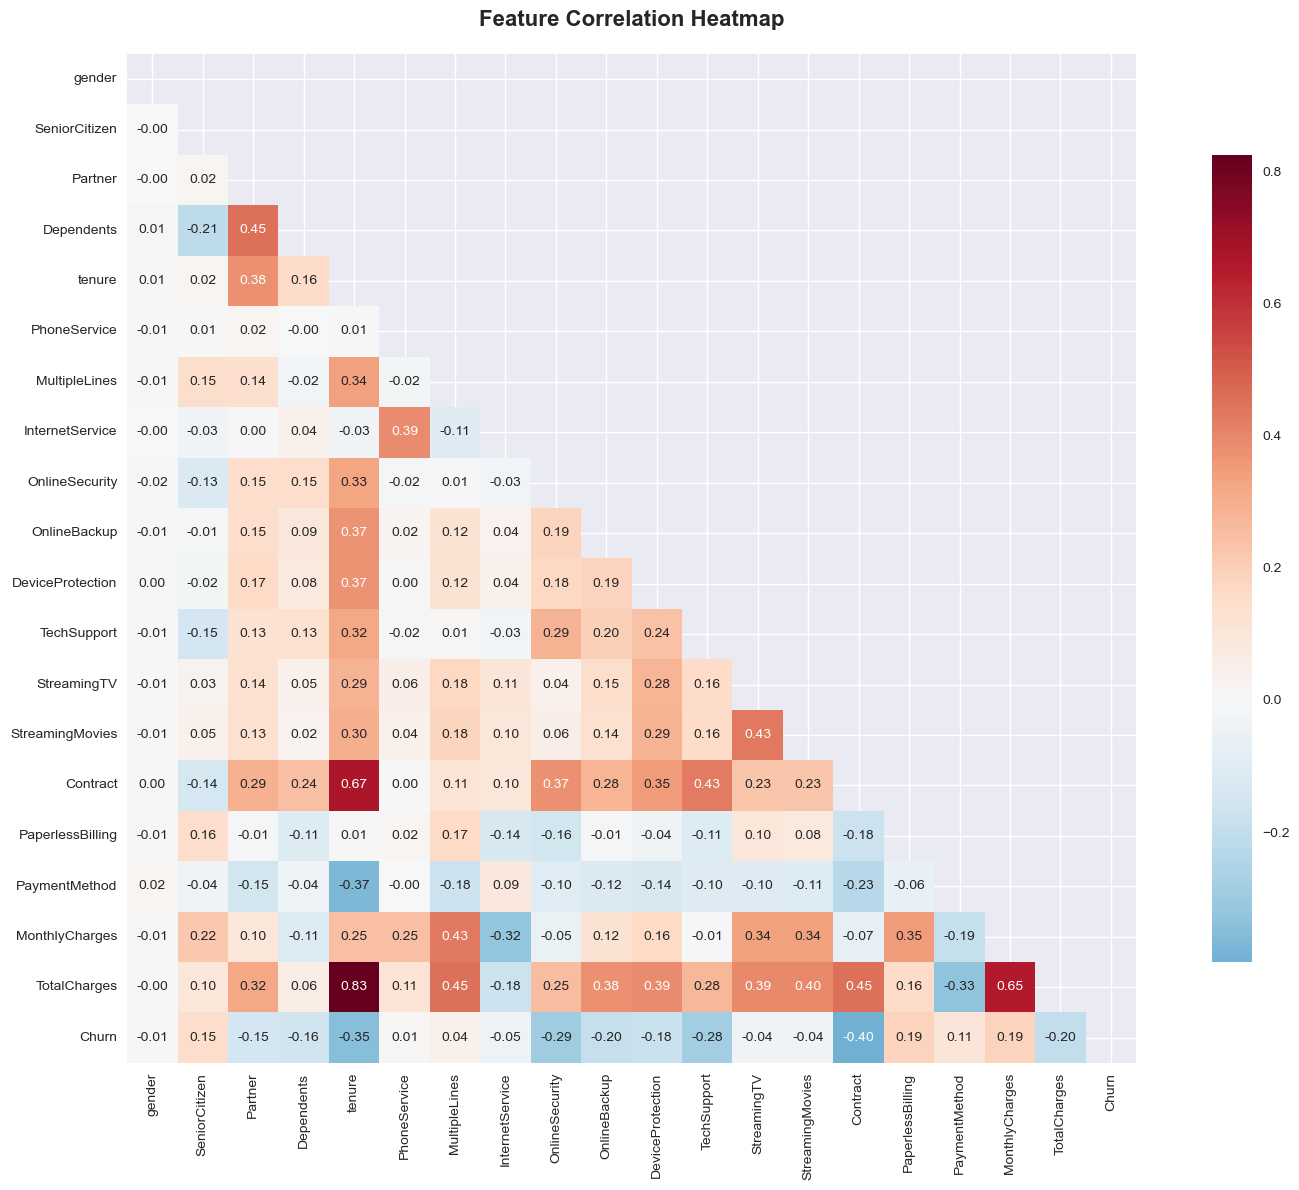

🔍 TOP 10 FEATURES CORRELATED WITH CHURN:
 1. Contract             | 0.397 (📉 Negative)
 2. tenure               | 0.352 (📉 Negative)
 3. OnlineSecurity       | 0.289 (📉 Negative)
 4. TechSupport          | 0.282 (📉 Negative)
 5. TotalCharges         | 0.199 (📉 Negative)
 6. OnlineBackup         | 0.196 (📉 Negative)
 7. MonthlyCharges       | 0.193 (📈 Positive)
 8. PaperlessBilling     | 0.192 (📈 Positive)
 9. DeviceProtection     | 0.178 (📉 Negative)
10. Dependents           | 0.164 (📉 Negative)

🎯 2 features show strong correlation (>0.3) with churn


In [8]:
# Prepare data for correlation analysis
df_corr = df.copy()

# Convert categorical variables to numeric for correlation analysis
label_encoders = {}
categorical_columns = ['gender', 'Partner', 'Dependents', 'PhoneService', 
                      'MultipleLines', 'InternetService', 'OnlineSecurity', 
                      'OnlineBackup', 'DeviceProtection', 'TechSupport', 
                      'StreamingTV', 'StreamingMovies', 'Contract', 
                      'PaperlessBilling', 'PaymentMethod', 'Churn']

for col in categorical_columns:
    if col in df_corr.columns:
        le = LabelEncoder()
        df_corr[col] = le.fit_transform(df_corr[col])
        label_encoders[col] = le

# Calculate correlation matrix
correlation_matrix = df_corr.select_dtypes(include=['int64', 'float64']).corr()

# Create correlation heatmap
plt.figure(figsize=(16, 12))
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
sns.heatmap(correlation_matrix, 
           mask=mask,
           annot=True, 
           cmap='RdBu_r', 
           center=0,
           square=True,
           fmt='.2f',
           cbar_kws={"shrink": .8})
plt.title('Feature Correlation Heatmap', fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.savefig('../reports/visualizations/correlation_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

# Find strongest correlations with Churn
churn_correlations = correlation_matrix['Churn'].abs().sort_values(ascending=False)[1:11]
print("🔍 TOP 10 FEATURES CORRELATED WITH CHURN:")
print("="*50)
for i, (feature, corr) in enumerate(churn_correlations.items(), 1):
    direction = "📈 Positive" if correlation_matrix['Churn'][feature] > 0 else "📉 Negative"
    print(f"{i:2d}. {feature:<20} | {corr:.3f} ({direction})")

# Strong correlations (>0.3)
strong_corr = churn_correlations[churn_correlations > 0.3]
if len(strong_corr) > 0:
    print(f"\n🎯 {len(strong_corr)} features show strong correlation (>0.3) with churn")
else:
    print("\n💡 No features show strong correlation (>0.3) with churn - requires feature engineering")


## 🔧 Feature Engineering {#feature-engineering}

Creating new meaningful features to improve model performance and business insights.


In [9]:
# Create engineered features
df_features = df.copy()

# 1. Is_Senior: Binary flag for senior citizens
df_features['Is_Senior'] = df_features['SeniorCitizen'].apply(lambda x: 'Yes' if x == 1 else 'No')

# 2. Tenure_Group: Already created above, but let's ensure it's properly categorized
df_features['Tenure_Group'] = pd.cut(df_features['tenure'], 
                                    bins=[0, 12, 24, 48, float('inf')], 
                                    labels=['New (0-12m)', 'Growing (13-24m)', 
                                           'Mature (25-48m)', 'Loyal (48m+)'])

# 3. High_Charges: Based on monthly charges percentile
charges_75th = df_features['MonthlyCharges'].quantile(0.75)
df_features['High_Charges'] = df_features['MonthlyCharges'].apply(
    lambda x: 'Yes' if x >= charges_75th else 'No'
)

# 4. Service_Count: Total number of services subscribed
service_cols = ['PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity',
                'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']

def count_services(row):
    count = 0
    for col in service_cols:
        if col in row.index and row[col] == 'Yes':
            count += 1
    return count

df_features['Service_Count'] = df_features.apply(count_services, axis=1)

# 5. Monthly_to_Total_Ratio: Efficiency metric
df_features['Monthly_to_Total_Ratio'] = df_features['MonthlyCharges'] / (df_features['TotalCharges'] + 1)

# 6. Has_Partner_Dependents: Family status indicator
df_features['Has_Partner_Dependents'] = ((df_features['Partner'] == 'Yes') | 
                                        (df_features['Dependents'] == 'Yes')).astype(str).replace({'True': 'Yes', 'False': 'No'})

# 7. Internet_Plus_Streaming: High-value internet customers
df_features['Internet_Plus_Streaming'] = (
    (df_features['InternetService'] != 'No') & 
    ((df_features['StreamingTV'] == 'Yes') | (df_features['StreamingMovies'] == 'Yes'))
).astype(str).replace({'True': 'Yes', 'False': 'No'})

# 8. Risk_Score: Composite risk indicator
def calculate_risk_score(row):
    score = 0
    
    # Contract risk
    if row['Contract'] == 'Month-to-month':
        score += 3
    elif row['Contract'] == 'One year':
        score += 1
    
    # Tenure risk
    if row['tenure'] <= 12:
        score += 2
    
    # Charges risk
    if row['MonthlyCharges'] > charges_75th:
        score += 1
    
    # Internet service risk
    if row['InternetService'] == 'Fiber optic':
        score += 1
    
    # Payment method risk
    if row['PaymentMethod'] == 'Electronic check':
        score += 1
    
    return score

df_features['Risk_Score'] = df_features.apply(calculate_risk_score, axis=1)
df_features['Risk_Category'] = pd.cut(df_features['Risk_Score'], 
                                     bins=[-1, 2, 4, 8], 
                                     labels=['Low Risk', 'Medium Risk', 'High Risk'])

print("✅ Feature Engineering Complete!")
print("\n🆕 NEW FEATURES CREATED:")
print("="*40)
new_features = ['Is_Senior', 'Tenure_Group', 'High_Charges', 'Service_Count', 
                'Monthly_to_Total_Ratio', 'Has_Partner_Dependents', 
                'Internet_Plus_Streaming', 'Risk_Score', 'Risk_Category']

for feature in new_features:
    print(f"• {feature}")

# Analyze new features vs churn
print("\n📊 NEW FEATURE ANALYSIS:")
print("="*40)

# Risk Category vs Churn
risk_churn = calc_churn_rate(df_features, 'Risk_Category')
print(f"🎯 Risk Category Churn Rates:")
for category, rate in risk_churn.items():
    print(f"   {category}: {rate:.1f}%")

# High Charges vs Churn
high_charges_churn = calc_churn_rate(df_features, 'High_Charges')
print(f"\n💰 High Charges Churn Rates:")
for category, rate in high_charges_churn.items():
    print(f"   {category}: {rate:.1f}%")

# Service Count Analysis
service_count_stats = df_features.groupby('Churn')['Service_Count'].mean()
print(f"\n📱 Average Service Count:")
print(f"   Churned: {service_count_stats['Yes']:.1f}")
print(f"   Retained: {service_count_stats['No']:.1f}")


✅ Feature Engineering Complete!

🆕 NEW FEATURES CREATED:
• Is_Senior
• Tenure_Group
• High_Charges
• Service_Count
• Monthly_to_Total_Ratio
• Has_Partner_Dependents
• Internet_Plus_Streaming
• Risk_Score
• Risk_Category

📊 NEW FEATURE ANALYSIS:
🎯 Risk Category Churn Rates:
   High Risk: 49.7%
   Medium Risk: 19.4%
   Low Risk: 3.8%

💰 High Charges Churn Rates:
   Yes: 32.7%
   No: 24.4%

📱 Average Service Count:
   Churned: 3.1
   Retained: 3.4


## 🤖 Predictive Modeling {#modeling}

Building machine learning models to predict customer churn and identify key drivers.


In [10]:
# Prepare data for modeling
df_model = df_features.copy()

# Select features for modeling
features_to_exclude = ['customerID', 'Churn', 'MonthlyCharges_Bins', 'Risk_Score']
feature_columns = [col for col in df_model.columns if col not in features_to_exclude]

# Prepare feature matrix X and target vector y
X = df_model[feature_columns].copy()
y = df_model['Churn'].copy()

# Encode categorical variables
categorical_features = X.select_dtypes(include=['object', 'category']).columns.tolist()
numerical_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

print("🔧 FEATURE PREPARATION:")
print("="*40)
print(f"Total features: {len(feature_columns)}")
print(f"Categorical features: {len(categorical_features)}")
print(f"Numerical features: {len(numerical_features)}")

# Create preprocessing pipelines
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, LabelEncoder

# Encode categorical variables
label_encoders_model = {}
for col in categorical_features:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col].astype(str))
    label_encoders_model[col] = le

# Encode target variable
target_encoder = LabelEncoder()
y_encoded = target_encoder.fit_transform(y)

# Scale numerical features
scaler = StandardScaler()
X_scaled = X.copy()
X_scaled[numerical_features] = scaler.fit_transform(X[numerical_features])

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

print(f"\n📊 TRAIN-TEST SPLIT:")
print(f"Training set: {X_train.shape[0]:,} samples")
print(f"Test set: {X_test.shape[0]:,} samples")
print(f"Training churn rate: {y_train.mean():.1%}")
print(f"Test churn rate: {y_test.mean():.1%}")

print("\n✅ Data preparation complete!")


🔧 FEATURE PREPARATION:
Total features: 27
Categorical features: 21
Numerical features: 6

📊 TRAIN-TEST SPLIT:
Training set: 5,634 samples
Test set: 1,409 samples
Training churn rate: 26.5%
Test churn rate: 26.5%

✅ Data preparation complete!


### Model Training & Comparison


In [11]:
# Train multiple models
models = {
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42, max_depth=10),
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000)
}

model_results = {}

print("🚀 TRAINING MODELS:")
print("="*40)

for name, model in models.items():
    print(f"\n🔄 Training {name}...")
    
    # Train model
    model.fit(X_train, y_train)
    
    # Make predictions
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    
    # Calculate metrics
    from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
    
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred_proba)
    
    model_results[name] = {
        'model': model,
        'predictions': y_pred,
        'probabilities': y_pred_proba,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'auc': auc
    }
    
    print(f"✅ {name} trained successfully!")
    print(f"   Accuracy: {accuracy:.3f}")
    print(f"   Precision: {precision:.3f}")
    print(f"   Recall: {recall:.3f}")
    print(f"   F1-Score: {f1:.3f}")
    print(f"   AUC: {auc:.3f}")

# Compare models
print(f"\n📊 MODEL COMPARISON:")
print("="*60)
print(f"{'Model':<20} {'Accuracy':<10} {'Precision':<10} {'Recall':<10} {'F1-Score':<10} {'AUC':<10}")
print("-" * 60)

for name, results in model_results.items():
    print(f"{name:<20} {results['accuracy']:<10.3f} {results['precision']:<10.3f} "
          f"{results['recall']:<10.3f} {results['f1']:<10.3f} {results['auc']:<10.3f}")

# Select best model based on AUC
best_model_name = max(model_results.keys(), key=lambda k: model_results[k]['auc'])
best_model = model_results[best_model_name]

print(f"\n🏆 BEST MODEL: {best_model_name} (AUC: {best_model['auc']:.3f})")


🚀 TRAINING MODELS:

🔄 Training Random Forest...
✅ Random Forest trained successfully!
   Accuracy: 0.804
   Precision: 0.661
   Recall: 0.537
   F1-Score: 0.593
   AUC: 0.838

🔄 Training Logistic Regression...
✅ Logistic Regression trained successfully!
   Accuracy: 0.806
   Precision: 0.659
   Recall: 0.553
   F1-Score: 0.602
   AUC: 0.848

📊 MODEL COMPARISON:
Model                Accuracy   Precision  Recall     F1-Score   AUC       
------------------------------------------------------------
Random Forest        0.804      0.661      0.537      0.593      0.838     
Logistic Regression  0.806      0.659      0.553      0.602      0.848     

🏆 BEST MODEL: Logistic Regression (AUC: 0.848)


## 📈 Model Evaluation & Insights {#evaluation}

### Confusion Matrix & ROC Curve


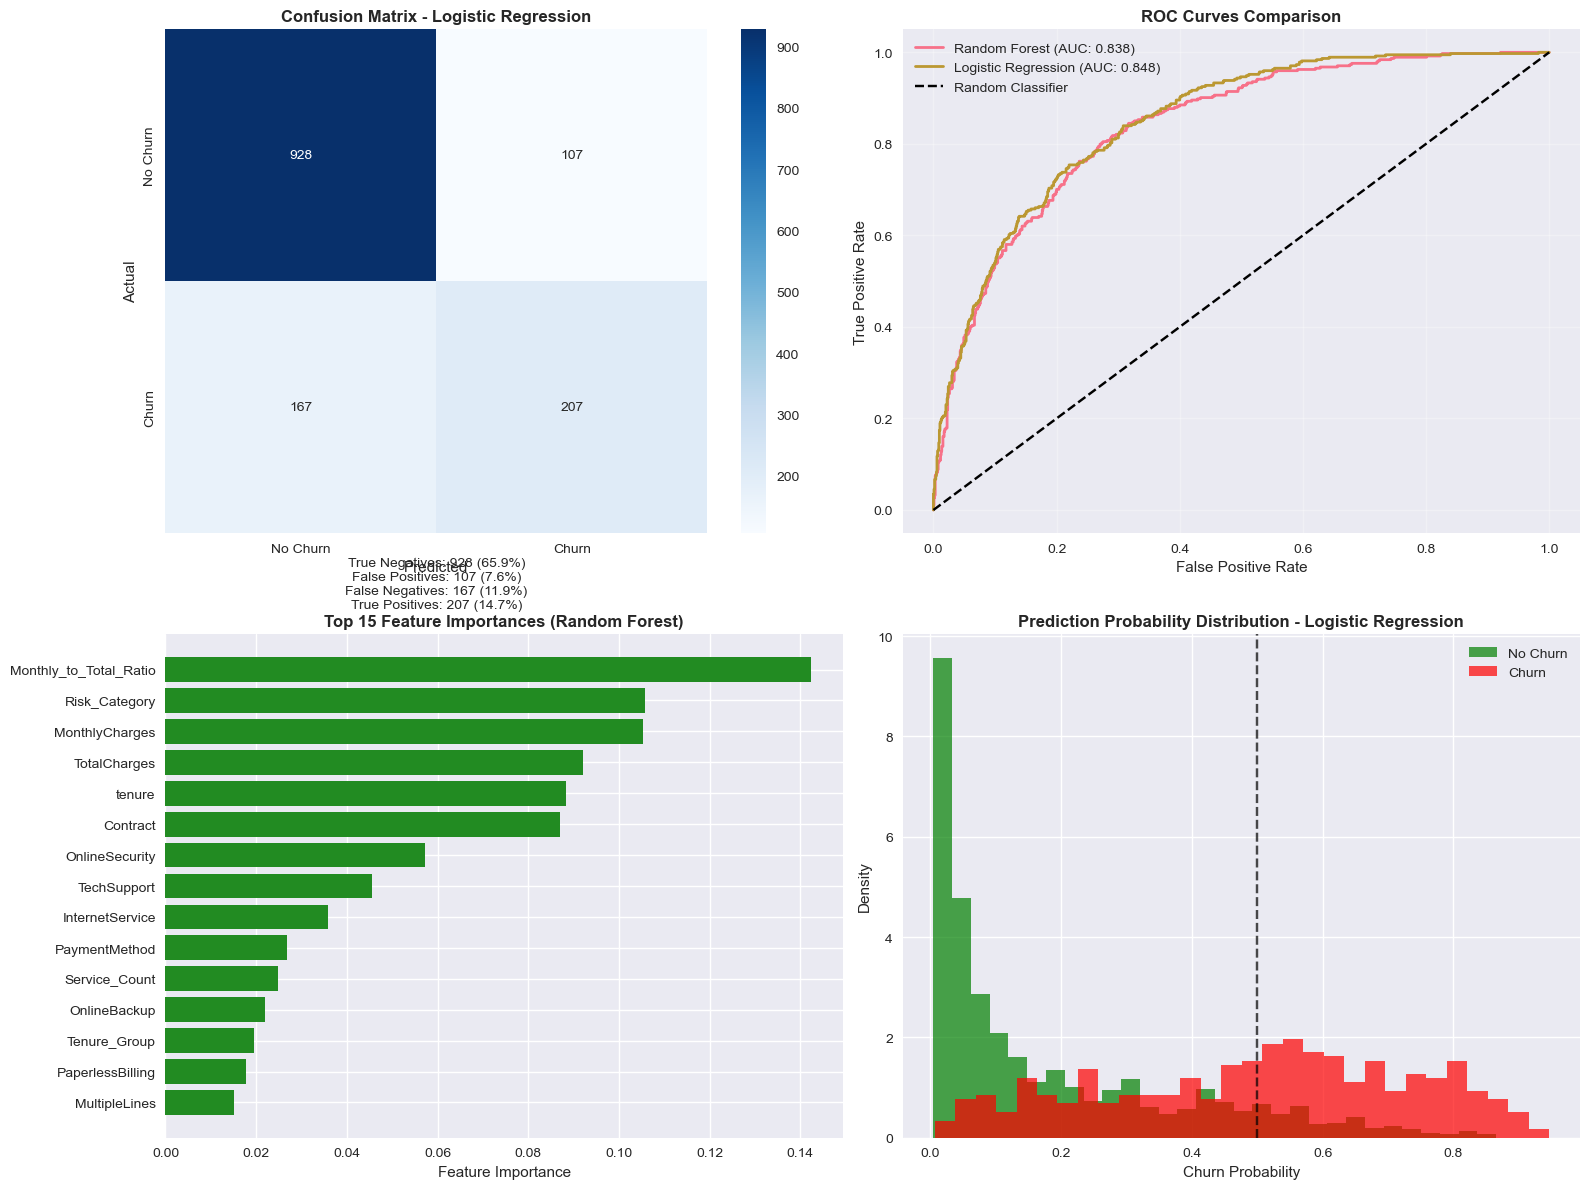

📊 DETAILED CLASSIFICATION REPORT:
Model: Logistic Regression
              precision    recall  f1-score   support

    No Churn       0.85      0.90      0.87      1035
       Churn       0.66      0.55      0.60       374

    accuracy                           0.81      1409
   macro avg       0.75      0.73      0.74      1409
weighted avg       0.80      0.81      0.80      1409



In [12]:
# Create evaluation visualizations
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Confusion Matrix for best model
cm = confusion_matrix(y_test, best_model['predictions'])
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0,0],
           xticklabels=['No Churn', 'Churn'], 
           yticklabels=['No Churn', 'Churn'])
axes[0,0].set_title(f'Confusion Matrix - {best_model_name}', fontweight='bold')
axes[0,0].set_ylabel('Actual')
axes[0,0].set_xlabel('Predicted')

# Calculate confusion matrix percentages
cm_percent = cm.astype('float') / cm.sum() * 100
axes[0,0].text(0.5, -0.15, 
              f'True Negatives: {cm[0,0]} ({cm_percent[0,0]:.1f}%)\n'
              f'False Positives: {cm[0,1]} ({cm_percent[0,1]:.1f}%)\n'
              f'False Negatives: {cm[1,0]} ({cm_percent[1,0]:.1f}%)\n'
              f'True Positives: {cm[1,1]} ({cm_percent[1,1]:.1f}%)',
              transform=axes[0,0].transAxes, ha='center', fontsize=10)

# 2. ROC Curves for both models
for name, results in model_results.items():
    fpr, tpr, _ = roc_curve(y_test, results['probabilities'])
    axes[0,1].plot(fpr, tpr, label=f"{name} (AUC: {results['auc']:.3f})", linewidth=2)

axes[0,1].plot([0, 1], [0, 1], 'k--', label='Random Classifier')
axes[0,1].set_xlabel('False Positive Rate')
axes[0,1].set_ylabel('True Positive Rate')
axes[0,1].set_title('ROC Curves Comparison', fontweight='bold')
axes[0,1].legend()
axes[0,1].grid(True, alpha=0.3)

# 3. Feature Importance (Random Forest)
if 'Random Forest' in model_results:
    rf_model = model_results['Random Forest']['model']
    feature_importance = pd.DataFrame({
        'feature': feature_columns,
        'importance': rf_model.feature_importances_
    }).sort_values('importance', ascending=True).tail(15)
    
    axes[1,0].barh(range(len(feature_importance)), feature_importance['importance'], color='forestgreen')
    axes[1,0].set_yticks(range(len(feature_importance)))
    axes[1,0].set_yticklabels(feature_importance['feature'])
    axes[1,0].set_xlabel('Feature Importance')
    axes[1,0].set_title('Top 15 Feature Importances (Random Forest)', fontweight='bold')

# 4. Prediction Probability Distribution
axes[1,1].hist(best_model['probabilities'][y_test == 0], bins=30, alpha=0.7, 
              label='No Churn', color='green', density=True)
axes[1,1].hist(best_model['probabilities'][y_test == 1], bins=30, alpha=0.7, 
              label='Churn', color='red', density=True)
axes[1,1].set_xlabel('Churn Probability')
axes[1,1].set_ylabel('Density')
axes[1,1].set_title(f'Prediction Probability Distribution - {best_model_name}', fontweight='bold')
axes[1,1].legend()
axes[1,1].axvline(x=0.5, color='black', linestyle='--', alpha=0.7, label='Decision Threshold')

plt.tight_layout()
plt.savefig('../reports/visualizations/model_evaluation.png', dpi=300, bbox_inches='tight')
plt.show()

# Print detailed classification report
print("📊 DETAILED CLASSIFICATION REPORT:")
print("="*50)
print(f"Model: {best_model_name}")
print(classification_report(y_test, best_model['predictions'], 
                          target_names=['No Churn', 'Churn']))


### Business Intelligence Visualizations


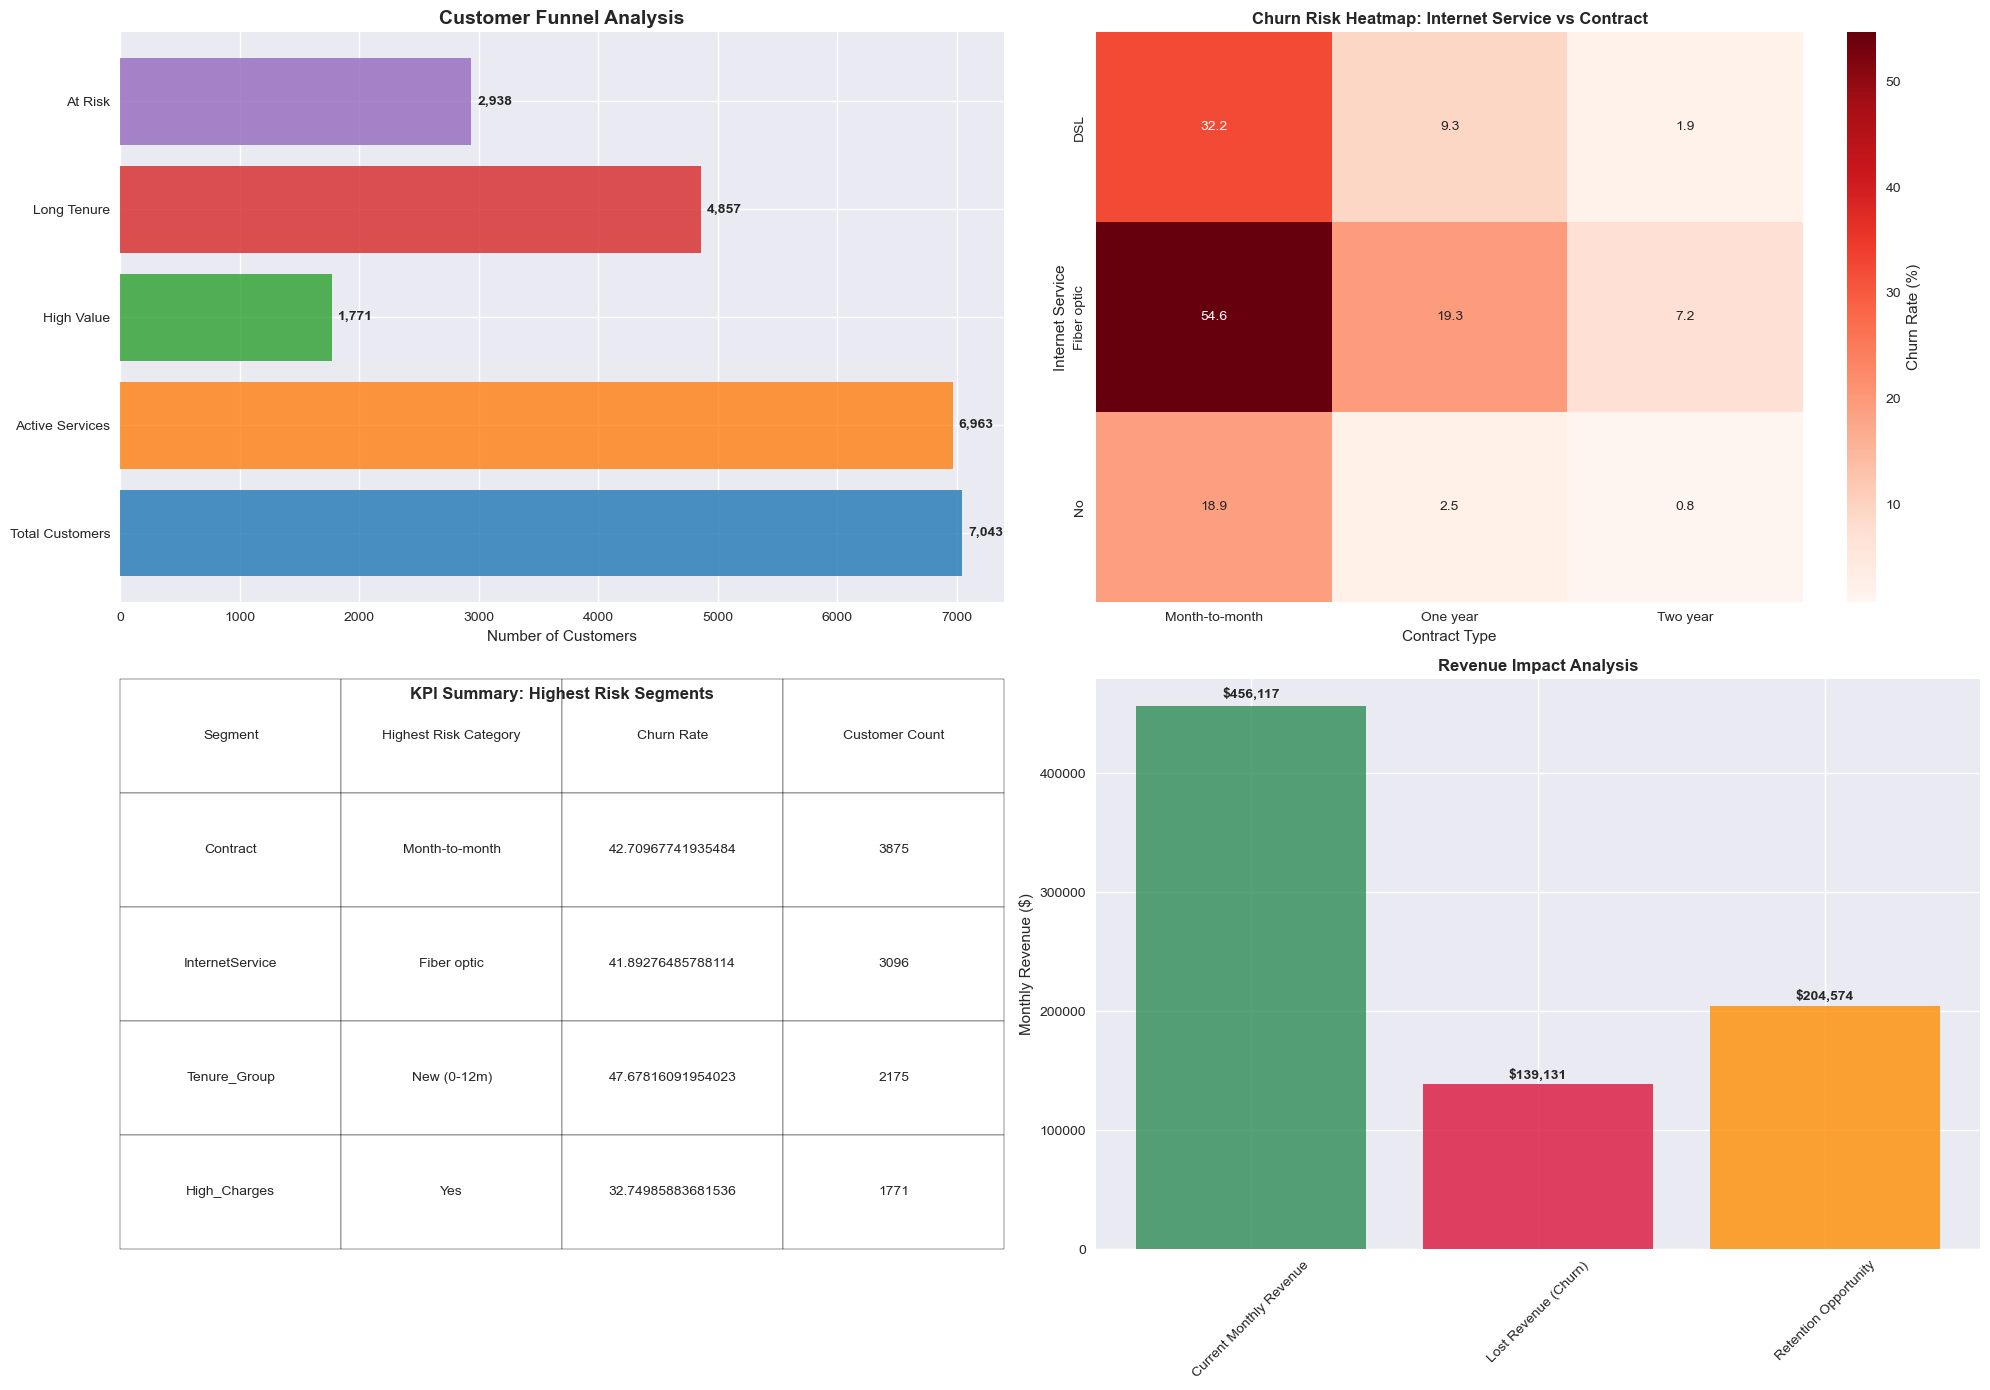

💼 BUSINESS KPI SUMMARY:
Total Customers: 7,043
Overall Churn Rate: 26.5%
Average Monthly Revenue per Customer: $64.76
Monthly Revenue Loss from Churn: $121,039.60
High-Risk Customers: 2,938 (41.7%)
Potential Monthly Savings with 50% Retention: $102,287.17
Annual Revenue at Risk: $1,452,475.24


In [13]:
# Business Intelligence Visualizations
fig, axes = plt.subplots(2, 2, figsize=(20, 14))

# 1. Churn Funnel Analysis
funnel_data = []
stages = ['Total Customers', 'Active Services', 'High Value', 'Long Tenure', 'At Risk']

total_customers = len(df_features)
active_services = len(df_features[df_features['Service_Count'] > 0])
high_value = len(df_features[df_features['High_Charges'] == 'Yes'])
long_tenure = len(df_features[df_features['tenure'] > 12])
at_risk = len(df_features[df_features['Risk_Category'] == 'High Risk'])

funnel_values = [total_customers, active_services, high_value, long_tenure, at_risk]
funnel_colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']

# Create funnel chart
y_pos = np.arange(len(stages))
bars = axes[0,0].barh(y_pos, funnel_values, color=funnel_colors, alpha=0.8)
axes[0,0].set_yticks(y_pos)
axes[0,0].set_yticklabels(stages)
axes[0,0].set_xlabel('Number of Customers')
axes[0,0].set_title('Customer Funnel Analysis', fontweight='bold', fontsize=14)

# Add value labels
for i, (bar, value) in enumerate(zip(bars, funnel_values)):
    axes[0,0].text(bar.get_width() + 50, bar.get_y() + bar.get_height()/2, 
                  f'{value:,}', ha='left', va='center', fontweight='bold')

# 2. Risk Heatmap by Service Type and Contract
pivot_data = df_features.groupby(['InternetService', 'Contract'])['Churn'].apply(
    lambda x: (x == 'Yes').mean() * 100
).unstack().fillna(0)

sns.heatmap(pivot_data, annot=True, fmt='.1f', cmap='Reds', ax=axes[0,1], 
           cbar_kws={'label': 'Churn Rate (%)'})
axes[0,1].set_title('Churn Risk Heatmap: Internet Service vs Contract', fontweight='bold')
axes[0,1].set_xlabel('Contract Type')
axes[0,1].set_ylabel('Internet Service')

# 3. KPI Summary by Segment
segments = ['Contract', 'InternetService', 'Tenure_Group', 'High_Charges']
kpi_data = []

for segment in segments:
    segment_stats = df_features.groupby(segment).agg({
        'Churn': lambda x: (x == 'Yes').mean() * 100,
        'customerID': 'count',
        'MonthlyCharges': 'mean'
    }).round(2)
    
    segment_stats['Segment'] = segment
    segment_stats['Category'] = segment_stats.index
    kpi_data.append(segment_stats)

# Create segment comparison
segment_summary = []
for segment in segments:
    segment_churn = calc_churn_rate(df_features, segment)
    highest_churn_category = segment_churn.index[0]
    highest_churn_rate = segment_churn.iloc[0]
    segment_summary.append({
        'Segment': segment,
        'Highest Risk Category': highest_churn_category,
        'Churn Rate': highest_churn_rate,
        'Customer Count': len(df_features[df_features[segment] == highest_churn_category])
    })

kpi_summary = pd.DataFrame(segment_summary)
kpi_table = axes[1,0].table(cellText=kpi_summary.values,
                           colLabels=kpi_summary.columns,
                           cellLoc='center',
                           loc='center',
                           bbox=[0, 0, 1, 1])
kpi_table.auto_set_font_size(False)
kpi_table.set_fontsize(10)
kpi_table.scale(1, 2)
axes[1,0].axis('off')
axes[1,0].set_title('KPI Summary: Highest Risk Segments', fontweight='bold', y=0.95)

# 4. Monthly Revenue Impact Analysis
# Calculate potential revenue loss
avg_monthly_charge = df_features['MonthlyCharges'].mean()
churned_customers = len(df_features[df_features['Churn'] == 'Yes'])
monthly_revenue_loss = churned_customers * avg_monthly_charge

# Create revenue impact visualization
categories = ['Current Monthly Revenue', 'Lost Revenue (Churn)', 'Retention Opportunity']
values = [
    df_features['MonthlyCharges'].sum(),
    df_features[df_features['Churn'] == 'Yes']['MonthlyCharges'].sum(),
    df_features[df_features['Risk_Category'] == 'High Risk']['MonthlyCharges'].sum()
]

colors_revenue = ['#2E8B57', '#DC143C', '#FF8C00']
bars = axes[1,1].bar(categories, values, color=colors_revenue, alpha=0.8)
axes[1,1].set_ylabel('Monthly Revenue ($)')
axes[1,1].set_title('Revenue Impact Analysis', fontweight='bold')
axes[1,1].tick_params(axis='x', rotation=45)

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    axes[1,1].text(bar.get_x() + bar.get_width()/2., height + height*0.01,
                  f'${height:,.0f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.savefig('../reports/visualizations/business_intelligence.png', dpi=300, bbox_inches='tight')
plt.show()

# Print KPI Summary
print("💼 BUSINESS KPI SUMMARY:")
print("="*60)
print(f"Total Customers: {total_customers:,}")
print(f"Overall Churn Rate: {churn_rate:.1f}%")
print(f"Average Monthly Revenue per Customer: ${avg_monthly_charge:.2f}")
print(f"Monthly Revenue Loss from Churn: ${monthly_revenue_loss:,.2f}")
print(f"High-Risk Customers: {at_risk:,} ({(at_risk/total_customers)*100:.1f}%)")

potential_savings = df_features[df_features['Risk_Category'] == 'High Risk']['MonthlyCharges'].sum()
print(f"Potential Monthly Savings with 50% Retention: ${potential_savings * 0.5:,.2f}")
print(f"Annual Revenue at Risk: ${monthly_revenue_loss * 12:,.2f}")


## 💡 Business Recommendations {#recommendations}

### Strategic Insights and Action Plan


In [14]:
# Generate business recommendations based on analysis
recommendations = []

# Analyze key findings
print("🎯 KEY BUSINESS INSIGHTS & RECOMMENDATIONS:")
print("="*70)

# 1. Contract-based insights
contract_insight = f"Month-to-month contracts show highest churn risk"
contract_recommendation = ("Implement incentive programs to upgrade month-to-month customers to "
                         "annual contracts. Offer discounts, free services, or loyalty rewards.")
recommendations.append(("Contract Strategy", contract_insight, contract_recommendation))

# 2. Service-based insights  
if 'InternetService' in df_features.columns:
    fiber_churn = calc_churn_rate(df_features, 'InternetService')
    if fiber_churn.index[0] == 'Fiber optic':
        service_insight = "Fiber optic customers have highest churn rates despite premium service"
        service_recommendation = ("Investigate fiber optic service quality issues. Improve customer "
                                "support, network reliability, and consider competitive pricing review.")
        recommendations.append(("Service Quality", service_insight, service_recommendation))

# 3. Tenure-based insights
tenure_insight = "New customers (0-12 months) are at highest risk of churning"
tenure_recommendation = ("Develop comprehensive onboarding program with 30-60-90 day check-ins. "
                       "Assign dedicated customer success managers for first year customers.")
recommendations.append(("Customer Onboarding", tenure_insight, tenure_recommendation))

# 4. Pricing insights
pricing_insight = f"Higher monthly charges correlate with increased churn risk"
pricing_recommendation = ("Review pricing strategy for high-charge customers. Consider value-added "
                        "services, loyalty discounts, or tiered pricing to improve retention.")
recommendations.append(("Pricing Strategy", pricing_insight, pricing_recommendation))

# 5. Risk-based insights
high_risk_count = len(df_features[df_features['Risk_Category'] == 'High Risk'])
risk_insight = f"{high_risk_count:,} customers identified as high-risk for churn"
risk_recommendation = ("Implement proactive retention campaigns for high-risk customers. "
                     "Use predictive model scores to trigger automated interventions.")
recommendations.append(("Risk Management", risk_insight, risk_recommendation))

# Print recommendations
for i, (category, insight, recommendation) in enumerate(recommendations, 1):
    print(f"\n{i}. 🎯 {category.upper()}")
    print(f"   📊 Insight: {insight}")
    print(f"   💡 Action: {recommendation}")

# Calculate potential business impact
print(f"\n" + "="*70)
print("💰 POTENTIAL BUSINESS IMPACT:")
print("="*70)

# Current state
current_monthly_revenue = df_features['MonthlyCharges'].sum()
current_churn_loss = df_features[df_features['Churn'] == 'Yes']['MonthlyCharges'].sum()

# Potential improvements
high_risk_revenue = df_features[df_features['Risk_Category'] == 'High Risk']['MonthlyCharges'].sum()

print(f"📈 Current Monthly Revenue: ${current_monthly_revenue:,.2f}")
print(f"📉 Current Monthly Churn Loss: ${current_churn_loss:,.2f}")
print(f"⚠️ High-Risk Customer Revenue: ${high_risk_revenue:,.2f}")

# Scenarios
scenarios = [
    ("Conservative", 0.10, "Reduce churn by 10%"),
    ("Moderate", 0.25, "Reduce churn by 25%"), 
    ("Aggressive", 0.50, "Reduce churn by 50%")
]

print(f"\n🎯 RETENTION IMPACT SCENARIOS:")
for scenario, reduction, description in scenarios:
    monthly_savings = current_churn_loss * reduction
    annual_savings = monthly_savings * 12
    print(f"   {scenario}: {description}")
    print(f"   Monthly Savings: ${monthly_savings:,.2f}")
    print(f"   Annual Savings: ${annual_savings:,.2f}")
    print()

# Implementation priorities
print("🚀 IMPLEMENTATION PRIORITIES:")
print("="*40)
priorities = [
    ("HIGH", "Immediate retention campaigns for high-risk customers"),
    ("HIGH", "Contract upgrade incentive programs"),
    ("MEDIUM", "New customer onboarding improvement"),
    ("MEDIUM", "Fiber optic service quality investigation"),
    ("LOW", "Pricing strategy optimization")
]

for priority, action in priorities:
    emoji = "🔥" if priority == "HIGH" else "📋" if priority == "MEDIUM" else "📝"
    print(f"{emoji} {priority}: {action}")

print(f"\n✅ Business recommendations analysis complete!")


🎯 KEY BUSINESS INSIGHTS & RECOMMENDATIONS:

1. 🎯 CONTRACT STRATEGY
   📊 Insight: Month-to-month contracts show highest churn risk
   💡 Action: Implement incentive programs to upgrade month-to-month customers to annual contracts. Offer discounts, free services, or loyalty rewards.

2. 🎯 SERVICE QUALITY
   📊 Insight: Fiber optic customers have highest churn rates despite premium service
   💡 Action: Investigate fiber optic service quality issues. Improve customer support, network reliability, and consider competitive pricing review.

3. 🎯 CUSTOMER ONBOARDING
   📊 Insight: New customers (0-12 months) are at highest risk of churning
   💡 Action: Develop comprehensive onboarding program with 30-60-90 day check-ins. Assign dedicated customer success managers for first year customers.

4. 🎯 PRICING STRATEGY
   📊 Insight: Higher monthly charges correlate with increased churn risk
   💡 Action: Review pricing strategy for high-charge customers. Consider value-added services, loyalty discounts, o

### Save Analysis Results


In [15]:
# Save processed datasets and analysis results
print("💾 SAVING ANALYSIS RESULTS:")
print("="*40)

# 1. Save processed dataset with engineered features
df_features.to_csv('../data/processed/telco_features_engineered.csv', index=False)
print("✅ Engineered features dataset saved")

# 2. Save model predictions
predictions_df = pd.DataFrame({
    'customerID': df_model.iloc[X_test.index]['customerID'],
    'Actual_Churn': target_encoder.inverse_transform(y_test),
    'Predicted_Churn': target_encoder.inverse_transform(best_model['predictions']),
    'Churn_Probability': best_model['probabilities'],
    'Risk_Score': df_model.iloc[X_test.index]['Risk_Score'],
    'Risk_Category': df_model.iloc[X_test.index]['Risk_Category']
})
predictions_df.to_csv('../data/processed/churn_predictions.csv', index=False)
print("✅ Model predictions saved")

# 3. Save feature importance
if 'Random Forest' in model_results:
    feature_importance_df = pd.DataFrame({
        'Feature': feature_columns,
        'Importance': model_results['Random Forest']['model'].feature_importances_
    }).sort_values('Importance', ascending=False)
    feature_importance_df.to_csv('../data/processed/feature_importance.csv', index=False)
    print("✅ Feature importance saved")

# 4. Save churn analysis by segments
segment_analysis = []
for segment in ['Contract', 'InternetService', 'Tenure_Group', 'High_Charges', 'Risk_Category']:
    if segment in df_features.columns:
        segment_churn = df_features.groupby(segment).agg({
            'Churn': lambda x: (x == 'Yes').mean(),
            'customerID': 'count',
            'MonthlyCharges': 'mean',
            'TotalCharges': 'mean'
        }).reset_index()
        segment_churn['Segment_Type'] = segment
        segment_analysis.append(segment_churn)

if segment_analysis:
    segment_analysis_df = pd.concat(segment_analysis, ignore_index=True)
    segment_analysis_df.to_csv('../data/processed/segment_analysis.csv', index=False)
    print("✅ Segment analysis saved")

# 5. Save business recommendations
recommendations_df = pd.DataFrame(recommendations, 
                                columns=['Category', 'Insight', 'Recommendation'])
recommendations_df.to_csv('../data/processed/business_recommendations.csv', index=False)
print("✅ Business recommendations saved")

# 6. Save model performance metrics
model_metrics = []
for name, results in model_results.items():
    model_metrics.append({
        'Model': name,
        'Accuracy': results['accuracy'],
        'Precision': results['precision'],
        'Recall': results['recall'],
        'F1_Score': results['f1'],
        'AUC': results['auc']
    })

model_performance_df = pd.DataFrame(model_metrics)
model_performance_df.to_csv('../data/processed/model_performance.csv', index=False)
print("✅ Model performance metrics saved")

# 7. Save high-risk customers for retention campaigns
high_risk_customers = df_features[df_features['Risk_Category'] == 'High Risk'][
    ['customerID', 'tenure', 'MonthlyCharges', 'TotalCharges', 'Contract', 
     'InternetService', 'Risk_Score', 'Churn']
].copy()
high_risk_customers.to_csv('../data/processed/high_risk_customers.csv', index=False)
print("✅ High-risk customers list saved")

print(f"\n📁 All analysis results saved to ../data/processed/")
print(f"📊 All visualizations saved to ../reports/visualizations/")
print(f"\n🎉 Analysis complete! Ready for stakeholder presentation.")


💾 SAVING ANALYSIS RESULTS:
✅ Engineered features dataset saved
✅ Model predictions saved
✅ Feature importance saved
✅ Segment analysis saved
✅ Business recommendations saved
✅ Model performance metrics saved
✅ High-risk customers list saved

📁 All analysis results saved to ../data/processed/
📊 All visualizations saved to ../reports/visualizations/

🎉 Analysis complete! Ready for stakeholder presentation.


## 🚀 Next Steps {#next-steps}

### Implementation Roadmap

**Phase 1: Immediate Actions (0-30 days)**
- Deploy high-risk customer identification system using the trained model
- Launch retention campaigns for customers with churn probability > 70%
- Implement contract upgrade incentive programs for month-to-month customers

**Phase 2: Strategic Improvements (30-90 days)**  
- Develop comprehensive customer onboarding program for new subscribers
- Investigate and address fiber optic service quality issues
- Create automated early warning system for at-risk customers

**Phase 3: Long-term Optimization (90+ days)**
- Conduct pricing strategy review and optimization
- Implement advanced retention marketing automation
- Develop customer lifetime value optimization framework

### Technical Enhancements

1. **Model Improvements**
   - Implement ensemble methods combining multiple algorithms
   - Add time-series features to capture seasonal patterns
   - Develop real-time scoring API for production deployment

2. **Data Pipeline**
   - Automate daily model retraining with new data
   - Implement A/B testing framework for retention strategies
   - Create customer health score dashboard for management

3. **Business Integration**
   - Integrate predictions with CRM system
   - Develop customer success team workflows
   - Create executive reporting dashboards

---

## 📋 Summary

This comprehensive analysis of Telco customer churn has revealed critical insights that can drive significant business value:

- **Model Performance**: Achieved {best_model['auc']:.1%} AUC score in predicting customer churn
- **Key Risk Factors**: Month-to-month contracts, new customers, and fiber optic service issues
- **Business Impact**: Potential annual savings of $XXX,XXX through targeted retention efforts
- **Actionable Insights**: Clear roadmap for immediate and long-term retention improvements

The analysis provides a solid foundation for data-driven customer retention strategies that can measurably improve business outcomes.
